### TEST 


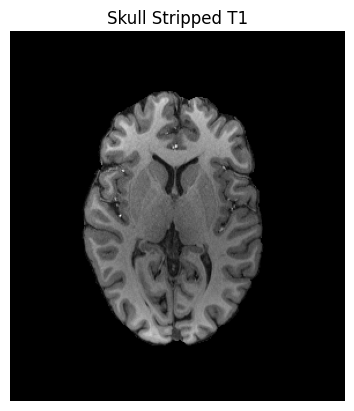

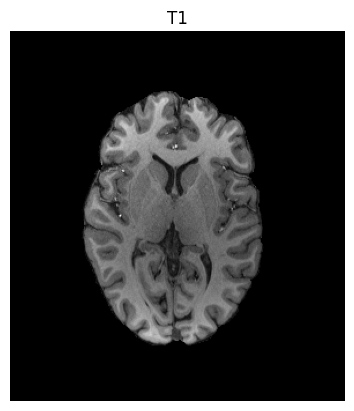

In [15]:
import nibabel as nib
import matplotlib.pyplot as plt

img = nib.load("/home/jovyan/data_fbaum/Toolbox/test_data/Demo_Data/ExBox18/T1_brain.nii.gz")
data = img.get_fdata()

plt.imshow(data[:, :, data.shape[2]//2].T, cmap='gray', origin='lower')
plt.title("Skull Stripped T1")
plt.axis('off')
plt.show()

img2 = nib.load("/home/jovyan/data_fbaum/Toolbox/test_data/Demo_Data/ExBox18/T1.nii.gz")
data = img.get_fdata()

plt.imshow(data[:, :, data.shape[2]//2].T, cmap='gray', origin='lower')
plt.title("T1")
plt.axis('off')
plt.show()

In [13]:
# Make sure the parent folder (Toolbox/) is on sys.path
import os, sys

# If this notebook lives in Toolbox/notebooks, this makes Toolbox/ visible:
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, repo_root)

print("Repo root =", repo_root)
print("sys.path[0]  =", sys.path[0])

from core.config.config_manager import ConfigManager
from core.pipeline.main_workflow   import MainWorkflow

# Load your config (adjust the relative path if need be)
cfg = ConfigManager(os.path.join(repo_root, "toolbox.ini"))

# Instantiate & run your main workflow
wf = MainWorkflow(cfg)
wf.base_dir = cfg.get("PATHS", "output_dir", fallback=os.path.join(repo_root, "results"))

# For debugging you can use a single‐threaded plugin
wf.run(plugin="Linear")

Repo root = /data/data_fbaum/Toolbox
sys.path[0]  = /data/data_fbaum/Toolbox
250630-09:25:04,433 nipype.workflow INFO:
	 Workflow MainWorkflow settings: ['check', 'execution', 'logging', 'monitoring']
250630-09:25:04,594 nipype.workflow INFO:
	 Running serially.
250630-09:25:04,595 nipype.workflow INFO:
	 [Node] Setting-up "MainWorkflow.io_workflow.make_paths" in "/data/data_fbaum/Toolbox/notebooks/results/MainWorkflow/io_workflow/make_paths".
250630-09:25:04,669 nipype.workflow INFO:
	 [Node] Executing "make_paths" <nipype.interfaces.utility.wrappers.Function>
250630-09:25:04,672 nipype.workflow INFO:
	 [Node] Finished "make_paths", elapsed time 0.000432s.
250630-09:25:04,705 nipype.workflow INFO:
	 [Node] Setting-up "MainWorkflow.parc_workflow.apply_parcellation" in "/data/data_fbaum/Toolbox/notebooks/results/MainWorkflow/parc_workflow/apply_parcellation".
250630-09:25:04,745 nipype.workflow INFO:
	 [Node] Executing "apply_parcellation" <nipype.interfaces.utility.wrappers.Function>
2

In [11]:
import sys
from core.config.config_manager import ConfigManager
from core.pipeline.main_workflow import MainWorkflow

cfg = ConfigManager("toolbox.ini")
wf = MainWorkflow(cfg)
wf.base_dir = cfg.get("PATHS", "output_dir", fallback="./results")
wf.run()


ModuleNotFoundError: No module named 'core'

## Exkurs/ Try-Out Codes

Idea: 3 options. Eather Atlas Alignment (e.g. Schäfer 400 onto subject T1) is done manually outside the toolbox (e.g. using ANTS or SPM) and user can insert the correct parcellation file into my toolbox (Option 1). Option 2: my toolbox integrates the external tools (e.g. ANTS can be called inside toolbox). Option 3: using centroid coordinates from Schäfer-400 atlas to "parcellate" the brain with only these coordinates. 

In [4]:
# Option1: Initialize Subject with Existing Native Parcellation
def initialize_subject(subject_id: str, t1_path: str, atlas_path: str, parcellated_atlas_path: str) -> dict:
    """
    Initializes a subject dictionary by storing the original T1, the original Schaefer atlas,
    and the already-parcellated atlas in native T1 space.

    Parameters:
    - subject_id: unique subject ID (e.g., 'sub-01')
    - t1_path: path to the native T1 image
    - atlas_path: path to the unaligned (MNI-space) Schaefer-400 atlas
    - parcellated_atlas_path: path to the parcellated atlas already transformed to native T1 space

    Returns:
    - subject_data: dictionary containing subject metadata and parcellation
    """
    # Load parcellated atlas image
    parcellation_img = nib.load(parcellated_atlas_path)
    data = parcellation_img.get_fdata().astype(int)

    # Extract unique ROI labels (exclude background)
    labels = [label for label in np.unique(data) if label != 0]

    # Build voxel dictionary: label → voxel coordinates
    voxels = {label: [tuple(coord) for coord in np.argwhere(data == label)] for label in labels}

    # Construct subject data dictionary
    subject_data = {
        "subject_id": subject_id,
        "t1_path": t1_path,
        "atlas_path": atlas_path,
        "transforms": {},  # Optionally include transform files later
        "parcellation": {
            "image": parcellation_img,
            "labels": labels,
            "voxels": voxels,
            "native_parcellation_path": parcellated_atlas_path
        },
        "modality_metadata": {}
    }

    return subject_data

In [3]:
# Option 2: Parcellate Atlas to Native Space (for later development) 
def parcellate_atlas_to_native(atlas_path: str, t1_path: str):
    """
    Resamples the atlas image to the subject's T1 space and extracts voxel indices per ROI.

    Returns:
    - parcellation_img: resampled atlas in native space
    - labels: list of ROI integers (excluding 0)
    - voxels: dict[label] = list of voxel coordinates
    """
    atlas_img = nib.load(atlas_path)
    t1_img = nib.load(t1_path)

    # Resample atlas to T1 resolution using nearest-neighbor interpolation
    parcellation_img = resample_to_img(source_img=atlas_img, target_img=t1_img, interpolation='nearest')
    data = parcellation_img.get_fdata().astype(int)

    # Extract labels (exclude 0)
    labels = [label for label in np.unique(data) if label != 0]

    # Map label to voxel coordinates
    voxels = {label: [tuple(coord) for coord in np.argwhere(data == label)] for label in labels}

    return parcellation_img, labels, voxels

In [5]:
# Option 3: Parcellate Atlas with Centroid Coordinates
def initialize_subject_centroid_based(subject_id: str, t1_path: str, centroid_csv_path: str) -> dict:
    """
    Initializes a subject dictionary using a native T1 image and Schaefer-400 centroid coordinates
    instead of a volumetric parcellation.

    Parameters:
    - subject_id: Unique subject ID
    - t1_path: Path to native T1 image
    - centroid_csv_path: Path to Schaefer centroid CSV file (in MNI space)

    Returns:
    - subject_data: Dictionary with centroids as 'parcellation'
    """

    # Load T1 image and get affine for potential coordinate transforms
    t1_img = nib.load(t1_path)
    t1_affine = t1_img.affine

    # Load centroid coordinates
    centroids_df = pd.read_csv(centroid_csv_path)
    centroids = {}

    for idx, row in centroids_df.iterrows():
        label = int(row['Label'])
        mni_coord = np.array([row['X'], row['Y'], row['Z'], 1])  # Homogeneous for affine
        voxel_coord = np.linalg.inv(t1_affine).dot(mni_coord)[:3]  # Project to voxel space

        # Optionally round voxel coordinate to nearest integer
        voxel_coord = tuple(np.round(voxel_coord).astype(int))

        centroids[label] = {
            "mni": (row['X'], row['Y'], row['Z']),
            "voxel": voxel_coord
        }

    # Subject dictionary
    subject_data = {
        "subject_id": subject_id,
        "t1_path": t1_path,
        "atlas_path": None,
        "transforms": {},
        "parcellation": {
            "type": "centroid_based",
            "centroids": centroids
        },
        "modality_metadata": {}
    }

    return subject_data